In [21]:
import numpy as np
from scipy.misc import logsumexp
import matplotlib.pyplot as plt

class HMM():
    def __init__(self, transition, mu,sigma, obs,T,pi, q):
        self.transition = transition #shape 4x4
        self.state=[0,1,2,3] #a modifier 
        self.pi=pi
        self.mu = mu
        self.sigma = sigma
        self.obs=obs
        self.T=T
        self.q=np.zeros(T)
        self.emissions = np.zeros((T, 4))
        self.label_cond_probas = np.zeros((T,4))

   
        
    def estimate_labels_cond_probas(self):
        for i, xi in enumerate(self.obs):
            probs = np.zeros(4)
            for q in self.state:
                prob = self.alphas[i,q] + self.betas[i,q]
               
                probs[q] = prob
  
            self.label_cond_probas[i] = np.exp(probs - logsumexp(probs))
        
         
    def estimate_emissions(self):
        
        for i,xi in enumerate(self.obs):
            probs = self.multivariate_gaussian(xi)
            self.emissions[i, :] = self.multivariate_gaussian(xi)
        
    
    def multivariate_gaussian(self, xi):
        """ Computes the vector of the probabilities p(u_t | q_t=i )"""
        probs = np.zeros(4)
        mu = self.mu
        sigmas = self.sigma
        inv_sigmas = [np.linalg.inv(sigmas[j]) for j in range(4)]
        det_sigmas = [np.linalg.det(sigmas[j]) for j in range(4)]
        for j in range(4):
            x_m = (xi-mu[j]).reshape(2,1)
            probs[j] = math.exp(- x_m.T.dot(inv_sigmas[j]).dot(x_m) / 2)
            probs[j] /= (2 * math.pi * math.sqrt(det_sigmas[j]))

       
        return probs
    
        
    def alpha_(self):
        alphas = np.zeros((self.T,4))
        alphas[0] = np.log(self.pi)
        
        for index in range(1,self.T):
            probs = np.log(self.emissions[index])
          
            result = np.zeros(4)
            for q in self.state:
                result[q] = probs[q] + logsumexp(np.log(self.transition[q,:]) + alphas[index-1])
             
            alphas[index] = result
        self.alphas = alphas


    def beta_(self): #forwoard
        betas = np.zeros((T,4))
        
        betas[(T-1)] = [0,0,0,0]
        for index in range((self.T-2),-1,-1):
            probs = np.log(self.emissions[index])
            result = np.zeros(4)
            for q in self.state:
                result[q] = probs[q] + logsumexp(np.log(self.transition[:,q]) + betas[index+1])
            betas[index] = result
        self.betas = betas

    def estimate_transition(self):
        new_transition = np.zeros((4,4))
        alphas = self.alphas
        betas = self.betas
        for k in range(4):
            for l in range(4):
                res=0
               
                for index in range(self.T):
                    
                    log_inter_prob = np.log(self.transition[k,l]) + np.log(self.emissions[index, l]) 
                    log_inter_prob += alphas[index,l] + betas[index,k]
                    log_inter_prob -= logsumexp(alphas[index,:] + betas[index,:])
                    res += np.exp(log_inter_prob)
                
                new_transition[k,l] = res 
                
            new_transition[k,:] /= np.sum(new_transition[k,:])
        
        self.transition = new_transition


    
    def estimate_mu(self):
        
        for k in range(4):
            res=0
            for index in range(self.T):
                res += self.label_cond_probas[index,k] * self.obs[index] 
            self.mu[k] = res / np.sum(self.label_cond_probas[:,k])
      
        return self.mu
    
    def estimate_sigma(self):                         
        for k in range(4):
            res=0
            for index in range(self.T):
                x_u = self.obs[index] - self.mu[k]
                x_u = x_u.reshape(2,1)
                res += self.label_cond_probas[index,k] * np.outer(x_u, x_u)
            self.sigma[k] = res / np.sum(self.label_cond_probas[:,k])
        
        return self.sigma
    
    
    def estimate_multinomial(self):
        for k in range(4):
            self.pi[k] = self.label_cond_probas[0,k] / np.sum(self.label_cond_probas[0,:])
        return self.pi
    
    
    def estimate_log_likelihood(self, q):
        loss = 0
        q = [int(r) for r in q]
        inv_sigmas = [np.linalg.inv(self.sigma[j]) for j in range(4)]
        det_sigmas = [np.linalg.det(self.sigma[j]) for j in range(4)]
        
        loss += np.log(self.pi[q[0]])
        
        for index in range(self.T-1):
            k = q[index]
            l = q[index + 1]
            loss += np.log(self.transition[k,l])
        
        for index in range(self.T):
            k = q[index]
            a = - np.log(det_sigmas[k]) / 2 - np.log(2 * np.pi) 
              
            x_u = self.obs[index] - self.mu[k]
            x_u = x_u.reshape(2,1)
            a -= x_u.T.dot(inv_sigmas[k]).dot(x_u) / 2
            loss += a 
            
        return -loss
   
            
    
 
       
    
    def plot(self):
        colors = ["green", "red", "orange", 'black']
        for k in range(4):

            X = [self.obs[i] for i in range(self.T) if self.q[i] == k]
            x = [a[0] for a in X]
            y = [a[1] for a in X]
      
        
            plt.scatter(x, y, c=colors[k])
        plt.show()
    
    def viterbi(self):
        self.estimate_emissions()
        viterbi = np.zeros((self.T, len(self.state)))
        viterbi[0,:] = np.log(self.pi) + np.log(self.emissions[0])
        phi = np.zeros((self.T, len(self.state)))
        phi[0,:] = 0
        for t in range(1,self.T):
            for j in range(len(self.state)):
                vtj = viterbi[t-1,:] + np.log(self.transition[:,j]) + np.log(self.emissions[t,j])
                viterbi[t,j] = np.max(vtj)
                phi[t,j] = np.argmax(vtj)
           
        prob = np.max(viterbi[self.T - 1])
        pointer = np.argmax(viterbi[self.T - 1])
        path = [pointer]
        for t in range(1,self.T):
            path = [phi[T - t, int(path[0])]] + path
    
        return path 
    
    """
    def mean_estimate_log_likelhood(self):
        loss = 0
        inv_sigmas = [np.linalg.inv(self.sigma[j]) for j in range(4)]
        det_sigmas = [np.linalg.det(self.sigma[j]) for j in range(4)]
        for q in self.state:
            loss += np.log(self.pi[q]) + np.log(self.label_cond_probas[0,q])
        for index in range(self.T):
            for k in range(4):
                for l in range(4):
                    log_inter_prob = np.log(self.transition[k,l]) + np.log(self.emissions[index, l]) 
                    log_inter_prob += self.alphas[index,l] + self.betas[index,k]
                    log_inter_prob /= logsumexp(self.alphas[index,:] + self.betas[index,:])
                    loss += np.log(self.transition[k,l]) * np.exp(log_inter_prob)
        
        for index in range(self.T):
            for k in range(4):
                a = - np.log(det_sigmas[k]) / 2 - np.log(2 * np.pi)
              
                x_u = self.obs[index] - self.mu[k]
                x_u = x_u.reshape(2,1)
                a -= x_u.T.dot(inv_sigmas[k]).dot(x_u) / 2
                loss -= a * self.label_cond_probas[index,k]
        return loss
    """  
        
    def fit(self, plot_errors=True): 
        errors = []
        N = 20
        for j in range(N):
           
            self.estimate_emissions()
           
            self.alpha_()
           
            self.beta_()
           
            self.estimate_labels_cond_probas()
           
            self.estimate_transition()
            self.estimate_mu()
            
            self.estimate_sigma()
            self.estimate_multinomial()
            
            errors += [self.estimate_log_likelihood(self.q)[0][0]]
            self.q = np.argmax(self.label_cond_probas, axis=1)

        
        if plot_errors:
            plt.plot(range(N), errors)
            plt.show()
            self.plot()
        return self.q
            


In [22]:
import pandas as pd

def read_file(filename):
    """ Load the data
    return:: x array, y array """
    print("Loading data " + filename)
    df = pd.read_csv(filename, delimiter=' ',  header=None)
    return df.values

filename = "EMGaussian.data"
filename_test = "EMGaussian.test"
x = read_file(filename)
x_test = read_file(filename_test)


Loading data EMGaussian.data
Loading data EMGaussian.test


Kmeans converged after 6 iterations, loss: 3240.173266
Fit Gaussian converged after 7 iterations


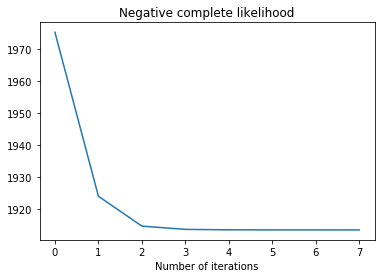

[[9.40690397e-01 1.22368210e-04 4.45398207e-02 1.46474138e-02]
 [1.99431052e-04 9.72191606e-01 1.61140822e-03 2.59975544e-02]
 [5.29405734e-02 9.15796448e-05 9.35304911e-01 1.16629356e-02]
 [6.03064063e-04 4.77981198e-04 2.45829808e-03 9.96460657e-01]]
[[9.99435475e-01 2.62961816e-08 3.14823450e-04 2.49675109e-04]
 [3.76615781e-06 9.98624905e-01 4.52074255e-04 9.19254258e-04]
 [1.55575289e-02 3.26640365e-07 9.84149183e-01 2.92961176e-04]
 [2.72500735e-07 8.37045174e-07 1.04545416e-04 9.99894345e-01]]
[[9.99991858e-01 2.81593240e-07 3.64608361e-06 4.21412917e-06]
 [6.44801118e-05 9.89750093e-01 5.21174378e-03 4.97368279e-03]
 [1.28761593e-01 2.87615187e-05 8.71158519e-01 5.11261125e-05]
 [1.04659892e-11 4.54254546e-06 1.16813875e-07 9.99995341e-01]]
[[9.99809532e-01 1.79732131e-04 1.06639322e-05 7.15264886e-08]
 [2.09599800e-03 9.82779434e-01 8.33836540e-03 6.78620260e-03]
 [8.50709473e-01 1.14493965e-05 1.49276290e-01 2.78725095e-06]
 [7.05267568e-22 6.02301880e-05 2.28853852e-11 9.999

/Users/danieltordjman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
/Users/danieltordjman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/Users/danieltordjman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


[[9.99106354e-01 8.93629871e-04 1.60542656e-08 4.49439363e-15]
 [7.82242917e-01 1.85164617e-01 2.27742044e-03 3.03150454e-02]
 [5.33435987e-02 1.51304954e-03 9.45138386e-01 4.96566913e-06]
 [2.86778265e-69 1.25427525e-04 5.12676674e-30 9.99874572e-01]]
[[9.99271049e-01 7.28933228e-04 1.82114384e-08 6.63699052e-17]
 [9.01195053e-01 6.32615657e-02 5.90369485e-04 3.49530116e-02]
 [7.12249638e-04 7.19681852e-04 9.98567097e-01 9.71441940e-07]
 [1.49480608e-79 1.04949885e-04 1.29511064e-32 9.99895050e-01]]
[[9.99256418e-01 7.43557135e-04 2.51219000e-08 9.82472579e-19]
 [9.54140963e-01 1.37557064e-02 1.26885213e-04 3.19764451e-02]
 [1.40036293e-06 1.22162718e-04 9.99876301e-01 1.35618995e-07]
 [5.33388987e-88 1.01370456e-04 1.65703568e-34 9.99898630e-01]]
[[9.98037201e-01 1.96275966e-03 3.92935293e-08 1.48179080e-20]
 [9.65500807e-01 1.63550624e-03 1.38222230e-05 3.28498643e-02]
 [3.21356759e-10 7.32401754e-06 9.99992664e-01 1.19575269e-08]
 [5.08370859e-94 1.35245882e-04 1.22310242e-35 9.998

/Users/danieltordjman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


[[9.88186730e-01 1.18130976e-02 1.72468036e-07 3.53180773e-22]
 [8.82480960e-01 1.33819440e-04 3.54164016e-07 1.17384867e-01]
 [4.73447302e-14 2.02496503e-07 9.99999796e-01 1.42017431e-09]
 [1.00444895e-96 2.10006902e-04 7.35735886e-36 9.99789993e-01]]
[[9.92588195e-01 7.41180262e-03 2.63877165e-09 3.15639996e-23]
 [2.33099141e-02 3.81121146e-07 1.15917128e-14 9.76689705e-01]
 [2.18453795e-14 5.71982751e-09 9.99991780e-01 8.21399991e-06]
 [1.21542229e-94 1.24242907e-03 7.09419996e-39 9.98757571e-01]]
[[8.77313862e-01 1.22686138e-01 1.38479682e-12 2.68365827e-24]
 [1.89831213e-03 3.28833763e-10 2.53911603e-26 9.98101688e-01]
 [4.03339066e-18 9.50659367e-10 3.39895009e-06 9.99996600e-01]
 [7.30743674e-93 6.01287490e-03 3.64016596e-42 9.93987125e-01]]
[[9.94726293e-01 5.27370725e-03 1.75639986e-15 1.05103117e-25]
 [1.39006907e-02 8.01005947e-13 6.91550144e-36 9.86099309e-01]
 [9.87438712e-28 5.00213325e-14 1.42616922e-16 1.00000000e+00]
 [7.46045438e-91 2.11170842e-02 6.44992206e-44 9.788

LinAlgError: Singular matrix

In [23]:
from emgaussian import EMGaussian
from kmean import KMeans
import matplotlib.pyplot as plt
import math
#Initialize parameters with EMGaussian

emg = EMGaussian(x, isotropic=False)
emg.fit(plot_likelihood=True)
plt.show()

pi=emg.pi
mu=emg.mu
sigma=emg.sigmas
transition = np.array([[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]])
obs = x
q = emg.labels
T = x.shape[0]

#HMM
model = HMM(transition, mu,sigma,obs,T,pi, q)
q = model.fit()


In [8]:
q = model.viterbi()
model.estimate_log_likelihood(q)

array([[2347.07590064]])

In [87]:
print(len(q))
print(model.T)

501
500
